# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [2]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader
    

In [3]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

100%|██████████| 170498071/170498071 [00:02<00:00, 84254139.35it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Посмотрим на изображения:

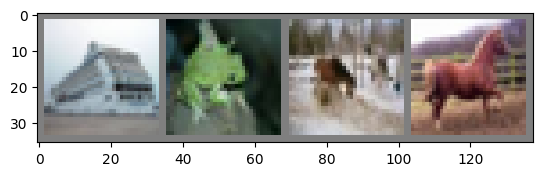

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [5]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32)
        )
        
        self.conv1x1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1)
        
        self.get_output = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(8),
            nn.Flatten(),
            nn.Linear(512, n_classes)
        )
        
        

    def forward(self, x):
        
        out = self.block(x)
        out = out + self.conv1x1(x)
        out = self.get_output(out)

        return out

In [6]:
net = BasicBlockNet()
net

BasicBlockNet(
  (block): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1x1): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (get_output): Sequential(
    (0): ReLU()
    (1): AvgPool2d(kernel_size=8, stride=8, padding=0)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)

Проверим, что выход сети имеет корректную размерность:

In [7]:
assert net(torch.randn((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [9]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [10]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    for data, target in loader:
        
        data, target = data.to(device), target.to(device)
        
        pred = model(data)
        
        loss = nn.CrossEntropyLoss()(pred, target)
        
        loss_log.append(loss.item())
        
        acc = (pred.argmax(axis = -1) == target).float().mean()
        
        acc_log.append(acc.item()) 
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    
    criterion = nn.CrossEntropyLoss()
    
    model.train()
    
    for data, target in train_loader:
        
        data, target = data.to(device), target.to(device)
        
        pred = model(data)
        loss = criterion(pred, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
        
        acc = (pred.argmax(axis = -1) == target).float().mean()
        
        acc_log.append(acc.item()) 

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            
            if type(scheduler).__name__ == 'ReduceLROnPlateau':
                scheduler.step(val_loss)
            
            else:
                scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [11]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.4796461429194951, train acc: 0.47198599511570205
 val loss: 1.2582519739232165, val acc: 0.552969858240574

Epoch 1
 train loss: 1.1907041255909085, train acc: 0.5833809414990859
 val loss: 1.1026704349416367, val acc: 0.6096631207364671

Epoch 2
 train loss: 1.0727984043318348, train acc: 0.6284645143113144
 val loss: 1.07573032962515, val acc: 0.6223404255319149

Epoch 3
 train loss: 1.005414731323828, train acc: 0.6502268870090436
 val loss: 0.9914657942792202, val acc: 0.6546099292471054

Epoch 4
 train loss: 0.968909803539569, train acc: 0.6631055758683729
 val loss: 1.0446706254431541, val acc: 0.6392287234042553

Epoch 5
 train loss: 0.9384073318685431, train acc: 0.6766330961553445
 val loss: 0.9846575899327055, val acc: 0.6574689716734785

Epoch 6
 train loss: 0.9159608047993572, train acc: 0.6819176025538819
 val loss: 0.9607626027249275, val acc: 0.6709441489361702

Epoch 7
 train loss: 0.8921916380224978, train acc: 0.6906339775709609
 val loss: 0.953

Посчитайте точность на тестовой выборке:

In [12]:
print(f'Accuracy Test: {test(net, test_loader)[1]:.2f}')

Accuracy Test: 0.68


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

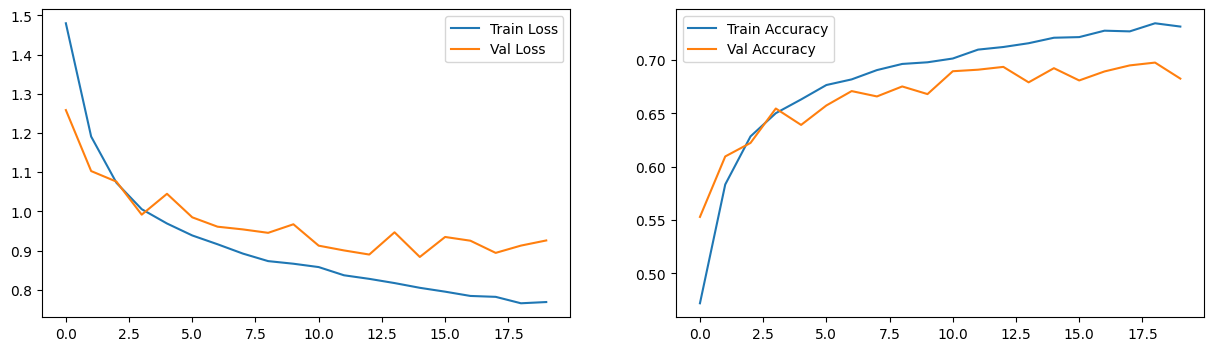

In [14]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(1, 2, figsize=(15, 4))


sns.lineplot(np.array(train_loss_log).reshape(20, -1).mean(axis = 1), 
             ax = ax[0], label = 'Train Loss')
sns.lineplot(np.array(train_acc_log).reshape(20, -1).mean(axis = 1), 
             ax = ax[1], label = 'Train Accuracy')

sns.lineplot(val_loss_log, ax = ax[0], label = 'Val Loss')
sns.lineplot(val_acc_log, ax = ax[1], label = 'Val Accuracy');

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [15]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.46315099061952, train acc: 0.48018004057394303
 val loss: 1.2254014568125948, val acc: 0.5664671986661058

Epoch 1
 train loss: 1.1485007360604824, train acc: 0.5980265735490231
 val loss: 1.0595535849003082, val acc: 0.6278590425531915

Epoch 2
 train loss: 1.0471532980092482, train acc: 0.633704132964014
 val loss: 1.0472978130299995, val acc: 0.6395168441407224

Epoch 3
 train loss: 0.9882483583699633, train acc: 0.6574048381400937
 val loss: 1.039060770704391, val acc: 0.6457003547790202

Epoch 4
 train loss: 0.9532316226845904, train acc: 0.6683084683618772
 val loss: 0.9765245008975901, val acc: 0.6627881207364671

Epoch 5
 train loss: 0.9204955668728356, train acc: 0.6810851397854318
 val loss: 0.9348033798501847, val acc: 0.6754654255319149

Epoch 6
 train loss: 0.8996722974986437, train acc: 0.6870266388713551
 val loss: 0.9547844100505748, val acc: 0.6734707446808511

Epoch 7
 train loss: 0.8845811601748632, train acc: 0.6951105054161448
 val loss: 1.01

Посчитайте точность на тестовой выборке:

In [16]:
print(f'Accuracy Test: {test(net, test_loader)[1]:.2f}')

Accuracy Test: 0.71


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [17]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.831453276508687, train acc: 0.3637535910937642
 val loss: 1.6239944594971678, val acc: 0.43093971635432954

Epoch 1
 train loss: 1.539503965778804, train acc: 0.4615026769624986
 val loss: 1.4579294798221993, val acc: 0.48867464547461653

Epoch 2
 train loss: 1.4256000529695472, train acc: 0.49653548579765194
 val loss: 1.3840728044509887, val acc: 0.5144281914893617

Epoch 3
 train loss: 1.3547030201341814, train acc: 0.5249779642826896
 val loss: 1.3198058458084756, val acc: 0.5372340425531915

Epoch 4
 train loss: 1.3010881805768615, train acc: 0.5422923740346863
 val loss: 1.2659700804568352, val acc: 0.5581781914893617

Epoch 5
 train loss: 1.2537095822407516, train acc: 0.5614757444130655
 val loss: 1.2322917981350676, val acc: 0.5660239361702127

Epoch 6
 train loss: 1.2134046965368923, train acc: 0.5765865762229375
 val loss: 1.195381747408116, val acc: 0.5785904255319149

Epoch 7
 train loss: 1.173728493929345, train acc: 0.591681085186423
 val loss: 1.1

In [18]:
print(f'Accuracy Test: {test(net, test_loader)[1]:.2f}')

Accuracy Test: 0.67


**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

> ### ExponentialLR
> #### Экспоненциально уменьшает значение `learning rate` по ходу обучения модели
> #### $$ \eta_t = \gamma \eta_{t-1}, \ \gamma < 1 $$

In [19]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.5550312017391978, train acc: 0.4479506725149137
 val loss: 1.4266297025883452, val acc: 0.49782801422666995

Epoch 1
 train loss: 1.2537395304692074, train acc: 0.5577827109061386
 val loss: 1.2038029292796522, val acc: 0.5761303191489362

Epoch 2
 train loss: 1.1063895213538593, train acc: 0.6121090689786391
 val loss: 1.0409092900600838, val acc: 0.6374113476022761

Epoch 3
 train loss: 1.02594815333539, train acc: 0.6429550797019624
 val loss: 1.0681347157092804, val acc: 0.6281028369639782

Epoch 4
 train loss: 0.9834364623212727, train acc: 0.6592003461211865
 val loss: 0.9896421980350576, val acc: 0.6534574468085106

Epoch 5
 train loss: 0.9503624992789037, train acc: 0.6684676155965551
 val loss: 0.9765547059951944, val acc: 0.6608820922831271

Epoch 6
 train loss: 0.927922323482346, train acc: 0.6787999478293075
 val loss: 0.9827863054072603, val acc: 0.6595301420130628

Epoch 7
 train loss: 0.9033572449326733, train acc: 0.6882957365002885
 val loss: 0.9

In [20]:
print(f'Accuracy Test: {test(net, test_loader)[1]:.2f}')

Accuracy Test: 0.70


> ### CosineLR
> #### Значение параметра `learning rate` изменяется по косинусоидальной функции, что означает, что значение параметра будет циклически изменяться и возвращаться к исходному значению
> #### $$ \eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})(1 + cos(\frac{T_{cur}}{T_{max}}\pi)) $$

In [21]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=75)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.5105101916210306, train acc: 0.46243307653685156
 val loss: 1.3099783491581045, val acc: 0.5471631206096487

Epoch 1
 train loss: 1.1770199166791313, train acc: 0.5869352311931101
 val loss: 1.1360039650125706, val acc: 0.6055186170212766

Epoch 2
 train loss: 1.0481206032650126, train acc: 0.6363606686130084
 val loss: 1.1539840502941863, val acc: 0.6016179079705096

Epoch 3
 train loss: 0.9945001822285068, train acc: 0.656245919315645
 val loss: 0.9736739153557635, val acc: 0.6644281914893617

Epoch 4
 train loss: 0.960168763749996, train acc: 0.6673943915794275
 val loss: 1.0082916381511282, val acc: 0.6583554965384463

Epoch 5
 train loss: 0.9239133638917201, train acc: 0.6795630387457895
 val loss: 1.0158881474048533, val acc: 0.6513962765957447

Epoch 6
 train loss: 0.9026793931803276, train acc: 0.6877774876258055
 val loss: 0.9365962591577084, val acc: 0.6762189718002969

Epoch 7
 train loss: 0.8856536039922529, train acc: 0.6928293941443755
 val loss: 0.

In [22]:
print(f'Accuracy Test: {test(net, test_loader)[1]:.2f}')

Accuracy Test: 0.70


> ### ReduceLR on plateu
> #### Заводится валидационная выборка, на которой считается значение функции потерь нак каждой эпохе. Если в течение нескольких эпох значение функции потерь на валидационной выборке не уменьшается, то значение `learning rate` уменьшается

In [23]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4551559026324117, train acc: 0.484628003410709
 val loss: 1.2075479525200865, val acc: 0.5801640071767442

Epoch 1
 train loss: 1.146878578654155, train acc: 0.5955047010285763
 val loss: 1.0966349959373474, val acc: 0.6184840425531914

Epoch 2
 train loss: 1.054018374443926, train acc: 0.6322962915221777
 val loss: 1.0116072368114553, val acc: 0.6457890071767441

Epoch 3
 train loss: 0.999027976061352, train acc: 0.6513286759256227
 val loss: 0.9951267414904655, val acc: 0.65288120584285

Epoch 4
 train loss: 0.9642582582599284, train acc: 0.6656682554503027
 val loss: 1.042338183331997, val acc: 0.6356826241980208

Epoch 5
 train loss: 0.9328140594623643, train acc: 0.6763760120602805
 val loss: 0.9561770596402757, val acc: 0.6706338654173182

Epoch 6
 train loss: 0.9063933129938254, train acc: 0.6855698289993258
 val loss: 0.9492574747572554, val acc: 0.6771498228641266

Epoch 7
 train loss: 0.8809116312747027, train acc: 0.6955920280224662
 val loss: 1.002314

In [24]:
print(f'Accuracy Test: {test(net, test_loader)[1]:.2f}')

Accuracy Test: 0.70


> ### Вывод:
> #### Рассматривались шедулеры `ReduceLR on plateu`, `CosineLR`, `ExponentialLR` и они сравнивались с `MultiStepLR`. При итоговом запуске качество всех тестируемых шедулеров получилось одинаковым, однако при нескольких экспериментах получились следующие результаты. Хуже всего себя показали `MultiStepLR` и `ExponentialLR`: значение `Accuracy` на тестовой выборке примерно равно 69%. Что касается `ReduceLR on plateu`, то с точки зрения принципа работы шедулера кажется, что он должен показывать наилучшее качество, поскольку по ходу обучения учитывает как изменяется качество модели. Однако качества моделей с использованием `ReduceLR on plateu` и `MultiStepLR` совпадают: 71%

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

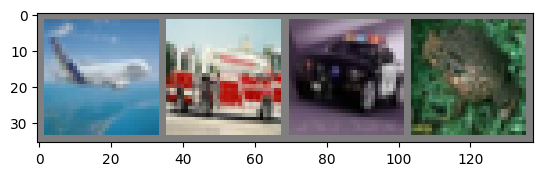

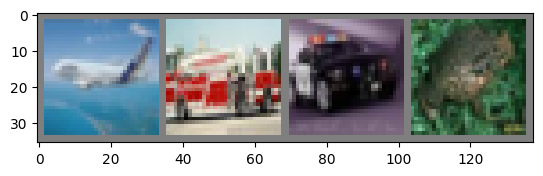

In [25]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [26]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4850030956582134, train acc: 0.46973344874338435
 val loss: 1.2974924072306206, val acc: 0.5341090425531915

Epoch 1
 train loss: 1.189714718671342, train acc: 0.5814507704984118
 val loss: 1.1130505526319463, val acc: 0.6106826241980208

Epoch 2
 train loss: 1.0622114939053273, train acc: 0.6279911530737031
 val loss: 1.060958538917785, val acc: 0.6361037234042554

Epoch 3
 train loss: 0.998620099515758, train acc: 0.6540668255886168
 val loss: 0.982962516267249, val acc: 0.6628324468085106

Epoch 4
 train loss: 0.9590254502279013, train acc: 0.6668271742747515
 val loss: 1.018132412687261, val acc: 0.644038120736467

Epoch 5
 train loss: 0.9221387431434129, train acc: 0.6816156307129799
 val loss: 0.9422862506927328, val acc: 0.6691046099713508

Epoch 6
 train loss: 0.9071626013768003, train acc: 0.68703071955571
 val loss: 0.9620513675060678, val acc: 0.6677304965384463

Epoch 7
 train

Посчитайте точность на тестовой выборке:

In [27]:
print(f'Accuracy Test: {test(net, test_loader)[1]:.2f}')

Accuracy Test: 0.73


**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

> ### ElasticTransform
> #### Создает "искаженную" версию исходного изображения

In [28]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

transform_elastic = transforms.Compose(
        [transforms.ElasticTransform(alpha=75.0),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64,
                                                         transform_train=transform)
train_loader_elastic, val_loader_elastic, test_loader_elastic = get_cifar10_data(batch_size=64, 
                                                                                 transform_train=transform_elastic)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


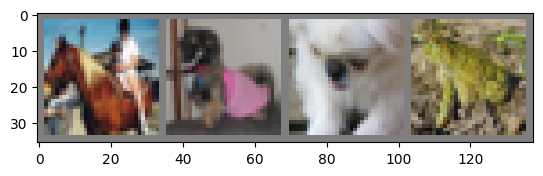

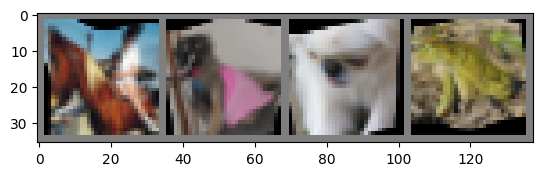

In [29]:
dataiter1, dataiter2 = iter(val_loader), iter(val_loader_elastic)
images1, labels1 = next(dataiter1)
images2, labels2 = next(dataiter2)

imshow(torchvision.utils.make_grid(images1[:4]))

imshow(torchvision.utils.make_grid(images2[:4]))

#### Только на искаженных изображениях

In [30]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader_elastic, val_loader, scheduler)

Epoch 0
 train loss: 1.62278316792448, train acc: 0.41661497781655904
 val loss: 1.4444175466578058, val acc: 0.4876329787234043

Epoch 1
 train loss: 1.4207452943163772, train acc: 0.48896986812734516
 val loss: 1.3566251217050755, val acc: 0.5320257093044037

Epoch 2
 train loss: 1.3073841869504186, train acc: 0.5338657286964779
 val loss: 1.285422485686363, val acc: 0.5640957446808511

Epoch 3
 train loss: 1.2394343896801336, train acc: 0.5615491969493887
 val loss: 1.1222199305574945, val acc: 0.612788120736467

Epoch 4
 train loss: 1.1901214170717451, train acc: 0.5788595260170304
 val loss: 1.1501032963712166, val acc: 0.6100177305809995

Epoch 5
 train loss: 1.1621737136919277, train acc: 0.5905099243089094
 val loss: 1.1287915556988817, val acc: 0.6166001773895101

Epoch 6
 train loss: 1.129083246374043, train acc: 0.6028662837183671
 val loss: 1.3147369648547882, val acc: 0.5793439718002968

Epoch 7
 train loss: 1.1124842190873252, train acc: 0.6082609689213894
 val loss: 1.12

In [31]:
print(f'Accuracy Test: {test(net, test_loader)[1]:.2f}')

Accuracy Test: 0.67


#### На объединенном датасете

In [32]:
from torch.utils.data import ConcatDataset, DataLoader

combined = ConcatDataset([train_loader.dataset, train_loader_elastic.dataset])
combined = DataLoader(combined, batch_size=64, shuffle=True)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, combined, val_loader, scheduler)

Epoch 0
 train loss: 1.45071680977314, train acc: 0.4819803092989669
 val loss: 1.2872607888059413, val acc: 0.5385416667512123

Epoch 1
 train loss: 1.1805626660095054, train acc: 0.5865564061911058
 val loss: 1.057173460848788, val acc: 0.6318927305809995

Epoch 2
 train loss: 1.0983032981373055, train acc: 0.6127932663373581
 val loss: 1.0690228634692254, val acc: 0.6301640071767441

Epoch 3
 train loss: 1.0527575614792337, train acc: 0.6286039381837932
 val loss: 0.9929112967024458, val acc: 0.6568705675449777

Epoch 4
 train loss: 1.0135148260776479, train acc: 0.6427435634123124
 val loss: 1.0015398875195929, val acc: 0.6582668441407225

Epoch 5
 train loss: 0.9871357925631229, train acc: 0.655254989372093
 val loss: 0.9758364893020468, val acc: 0.6646941489361702

Epoch 6
 train loss: 0.9680470931028753, train acc: 0.6607394500667914
 val loss: 0.9695714864325016, val acc: 0.6747118795171697

Epoch 7
 train loss: 0.9530081724989785, train acc: 0.66700468464351
 val loss: 0.94174

In [33]:
print(f'Accuracy Test: {test(net, test_loader)[1]:.2f}')

Accuracy Test: 0.73


> ### GrayScale
> #### Создает черно-белую версию исходного изображения

In [34]:
transform_grayscale = transforms.Compose(
        [transforms.Grayscale(3),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader_gscale, val_loader_gscale, test_loader_gscale = get_cifar10_data(batch_size=64, 
                                                                                 transform_train=transform_grayscale)

Files already downloaded and verified
Files already downloaded and verified


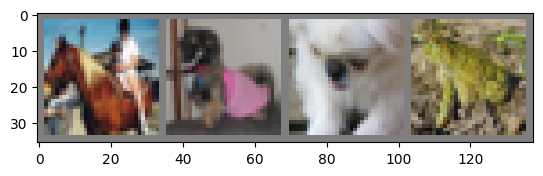

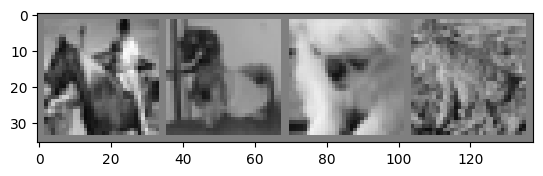

In [35]:
dataiter2 = iter(val_loader_gscale)
images2, labels2 = next(dataiter2)

imshow(torchvision.utils.make_grid(images1[:4]))

imshow(torchvision.utils.make_grid(images2[:4]))

#### Только на ч/б изображениях

In [36]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader_gscale, val_loader, scheduler)

Epoch 0
 train loss: 1.551947481017662, train acc: 0.4537167015197726
 val loss: 1.3088413167507091, val acc: 0.544747340425532

Epoch 1
 train loss: 1.2294356608303636, train acc: 0.5755255942588751
 val loss: 1.148255203886235, val acc: 0.6046985816448293

Epoch 2
 train loss: 1.1415732944251415, train acc: 0.6078814638598091
 val loss: 1.1486781531191887, val acc: 0.6014849292471054

Epoch 3
 train loss: 1.0873175716705252, train acc: 0.6270158658079953
 val loss: 1.0736522240841642, val acc: 0.6273714539852548

Epoch 4
 train loss: 1.0456484288140668, train acc: 0.6415594803131912
 val loss: 1.1331124944889799, val acc: 0.6226728723404256

Epoch 5
 train loss: 1.0189991660920097, train acc: 0.6528466962809101
 val loss: 1.093612685863008, val acc: 0.6196365249917862

Epoch 6
 train loss: 0.9935228727635343, train acc: 0.661044822423506
 val loss: 1.1244172387934745, val acc: 0.6195700356300841

Epoch 7
 train loss: 0.9757554975680502, train acc: 0.6698428115635511
 val loss: 1.0010

In [37]:
print(f'Accuracy Test: {test(net, test_loader)[1]:.2f}')

Accuracy Test: 0.68


#### На объединенном датасете 

In [38]:
combined = ConcatDataset([train_loader.dataset, train_loader_gscale.dataset])
combined = DataLoader(combined, batch_size=64, shuffle=True)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, combined, val_loader, scheduler)

Epoch 0
 train loss: 1.4188193571523948, train acc: 0.5021899756609413
 val loss: 1.1846879167759672, val acc: 0.5916001773895101

Epoch 1
 train loss: 1.1222817217301189, train acc: 0.6126885283363802
 val loss: 1.0359748969686793, val acc: 0.6351063829787233

Epoch 2
 train loss: 1.0288039023087272, train acc: 0.643086342205731
 val loss: 1.0031507489529061, val acc: 0.6542553191489362

Epoch 3
 train loss: 0.9816465566319565, train acc: 0.6617201782449725
 val loss: 1.0119230351549513, val acc: 0.6578900710065314

Epoch 4
 train loss: 0.9387657608584904, train acc: 0.6759216941252922
 val loss: 0.9289905923478147, val acc: 0.6754875888215734

Epoch 5
 train loss: 0.9047311023013901, train acc: 0.6898470826079248
 val loss: 0.935484675650901, val acc: 0.6811613476022761

Epoch 6
 train loss: 0.8812649382424746, train acc: 0.6967931139730666
 val loss: 0.9329617051368064, val acc: 0.6890070922831272

Epoch 7
 train loss: 0.8674998311717506, train acc: 0.6984451173428425
 val loss: 0.8

In [39]:
print(f'Accuracy Test: {test(net, test_loader)[1]:.2f}')

Accuracy Test: 0.73


> ### RandomPerspective
> #### Создает рандомную перспективу исходного изображения ("наклоны")

In [40]:
transform_rperspective = transforms.Compose(
        [transforms.RandomPerspective(distortion_scale=0.4, p=1),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader_rper, val_loader_rper, test_loader_rper = get_cifar10_data(batch_size=64, 
                                                                                 transform_train=transform_rperspective)

Files already downloaded and verified
Files already downloaded and verified


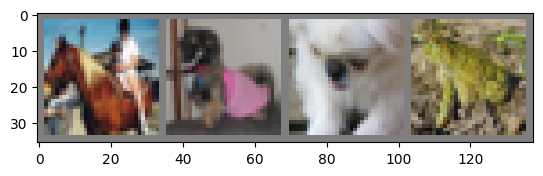

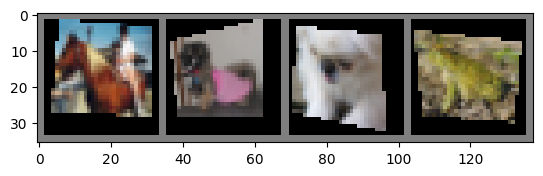

In [41]:
dataiter2 = iter(val_loader_rper)
images2, labels2 = next(dataiter2)

imshow(torchvision.utils.make_grid(images1[:4]))

imshow(torchvision.utils.make_grid(images2[:4]))

#### Только на искаженных изображениях

In [42]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader_rper, val_loader, scheduler)

Epoch 0
 train loss: 1.6940113663455467, train acc: 0.38454883784001226
 val loss: 1.503929007307012, val acc: 0.46739804972993565

Epoch 1
 train loss: 1.4615001196835116, train acc: 0.47420181511089177
 val loss: 1.4572055431122475, val acc: 0.49250886529049975

Epoch 2
 train loss: 1.3619307675134984, train acc: 0.5113565879286535
 val loss: 1.3608256256326716, val acc: 0.5268617021276596

Epoch 3
 train loss: 1.2662100925959878, train acc: 0.5477197049304816
 val loss: 1.2195742883580796, val acc: 0.5855053191489362

Epoch 4
 train loss: 1.2050774349155111, train acc: 0.5711470031651108
 val loss: 1.2547775271091055, val acc: 0.585128546268382

Epoch 5
 train loss: 1.1623121927163718, train acc: 0.5884573322327525
 val loss: 1.1410062295325258, val acc: 0.6091533688788718

Epoch 6
 train loss: 1.1229787237901356, train acc: 0.6008055301645339
 val loss: 1.134323114790815, val acc: 0.6191046100981692

Epoch 7
 train loss: 1.101051391369682, train acc: 0.6119621637970264
 val loss: 1

In [43]:
print(f'Accuracy Test: {test(net, test_loader)[1]:.2f}')

Accuracy Test: 0.65


#### На объединенном датасете 

In [44]:
combined = ConcatDataset([train_loader.dataset, train_loader_rper.dataset])
combined = DataLoader(combined, batch_size=64, shuffle=True)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, combined, val_loader, scheduler)

Epoch 0
 train loss: 1.538127377002723, train acc: 0.44695022092005016
 val loss: 1.2097530106280712, val acc: 0.5730053191489362

Epoch 1
 train loss: 1.2215016327893713, train acc: 0.5680463513464988
 val loss: 1.174509063933758, val acc: 0.5966090425531915

Epoch 2
 train loss: 1.1119436727908236, train acc: 0.6111174588665448
 val loss: 1.0717965757593195, val acc: 0.6283909574468085

Epoch 3
 train loss: 1.0623918423595986, train acc: 0.6276327316024404
 val loss: 1.0143362369943172, val acc: 0.6548537234042553

Epoch 4
 train loss: 1.0253866369916054, train acc: 0.6423436548199907
 val loss: 0.9838777204777333, val acc: 0.659663120736467

Epoch 5
 train loss: 1.0040403794109058, train acc: 0.6516748552893372
 val loss: 0.9675429757605207, val acc: 0.6690381207364671

Epoch 6
 train loss: 0.9807489328563105, train acc: 0.6571783592321755
 val loss: 0.9336376588395301, val acc: 0.6810062058428501

Epoch 7
 train loss: 0.9637303028180787, train acc: 0.6639482404021938
 val loss: 0.9

In [45]:
print(f'Accuracy Test: {test(net, test_loader)[1]:.2f}')

Accuracy Test: 0.73


> ### На всех измененных датасетах + исходный датасет 

In [49]:
combined = ConcatDataset([train_loader.dataset, 
                          train_loader_rper.dataset,
                          train_loader_gscale.dataset,
                          train_loader_elastic.dataset
                         ])
combined = DataLoader(combined, batch_size=64, shuffle=True)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, combined, val_loader, scheduler)

Epoch 0
 train loss: 1.411778031635546, train acc: 0.49730775822669104
 val loss: 1.259246267156398, val acc: 0.554188829787234

Epoch 1
 train loss: 1.149555303006547, train acc: 0.5975705553016454
 val loss: 1.0560322632180883, val acc: 0.6340203901554676

Epoch 2
 train loss: 1.0710768547092975, train acc: 0.6257498286106032
 val loss: 0.9512087132068391, val acc: 0.6715647164811479

Epoch 3
 train loss: 1.0244829592037898, train acc: 0.6425245658135283
 val loss: 0.9903609187044996, val acc: 0.6702127659574468

Epoch 4
 train loss: 0.986812918166029, train acc: 0.6576282563985375
 val loss: 1.086919438585322, val acc: 0.6392065603682335

Epoch 5
 train loss: 0.9658575646947027, train acc: 0.6638625457038391
 val loss: 0.9022642906675947, val acc: 0.6900709220703612

Epoch 6
 train loss: 0.9451734795485379, train acc: 0.6717393167276051
 val loss: 0.8957770378031629, val acc: 0.6934618795171698

Epoch 7
 train loss: 0.926736473574063, train acc: 0.6773594606946983
 val loss: 0.87817

In [50]:
print(f'Accuracy Test: {test(net, test_loader)[1]:.2f}')

Accuracy Test: 0.75


> ### Вывод:
> #### Аугментация данных действительно улучшило качество модели за счет увеличения обучающей выборки. Если до аугментации качество было 0.71 на тестовой выборки, то после аугментации качество увеличилось вплоть до 0.75 на тестовой выборке

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [47]:
import wandb

def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    for data, target in loader:
        
        data, target = data.to(device), target.to(device)
        
        pred = model(data)
        
        loss = nn.CrossEntropyLoss()(pred, target)
        
        loss_log.append(loss.item())
        
        acc = (pred.argmax(axis = -1) == target).float().mean()
        
        acc_log.append(acc.item()) 
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    
    criterion = nn.CrossEntropyLoss()
    
    model.train()
    
    for data, target in train_loader:
        
        data, target = data.to(device), target.to(device)
        
        pred = model(data)
        loss = criterion(pred, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
        
        acc = (pred.argmax(axis = -1) == target).float().mean()
        
        acc_log.append(acc.item()) 

    return loss_log, acc_log

def train_new(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        wandb.log({"Accuracy Val": val_acc, 
                   "Loss val": val_loss,
                   "Accuracy Train": np.mean(train_acc),
                   "Loss Train": np.mean(train_loss)}
                 )

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

wandb.init(
    
    project="HW-2 Task 2.1",

    config={
    "learning_rate": 0.1,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 20,
    }
)

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train_new(net, optimizer, 20, train_loader, val_loader)

wandb.log({"Accuracy Train Final": round(test(net, train_loader)[0], 2)})
wandb.log({"Accuracy Test": round(test(net, test_loader)[0], 2)})


# wandb.finish()

Epoch 0
 train loss: 0.8241100758041716, train acc: 0.7150610472863945
 val loss: 0.9333229425105642, val acc: 0.6871453901554676

Epoch 1
 train loss: 0.7938542153543267, train acc: 0.726470684329596
 val loss: 0.8689535693919405, val acc: 0.704410461161999

Epoch 2
 train loss: 0.7778685399666565, train acc: 0.7297882933503314
 val loss: 0.8973963871915289, val acc: 0.692974290949233

Epoch 3
 train loss: 0.7657773123144885, train acc: 0.735917504570384
 val loss: 0.9160365696917189, val acc: 0.6981826241980208

Epoch 4
 train loss: 0.7661220078276542, train acc: 0.7350768804332238
 val loss: 0.8791981745273509, val acc: 0.7010195037151905

Epoch 5
 train loss: 0.7545536841509329, train acc: 0.7380517106605404
 val loss: 0.8591015167692875, val acc: 0.7083554965384463

Epoch 6
 train loss: 0.7422743867367669, train acc: 0.7432709258914648
 val loss: 0.9748897709745041, val acc: 0.6761303191489362

Epoch 7
 train loss: 0.7371948252430346, train acc: 0.7461110929902337
 val loss: 0.864

In [48]:
wandb.log({"Accuracy Train Final2": round(test(net, train_loader)[1], 2)})
wandb.log({"Accuracy Test2": round(test(net, test_loader)[1], 2)})

> #### Ссылка на дешборд
> https://wandb.ai/vsevolodparamonovv-hse/HW-2%20Task%202.1/runs/5pdsp0s9